## Optimising Dream 11 Team Selection ##

### Section 1.1 Data Preparation :
1) Prepare a Score Vector (The mean of a Player's Score across 10 Matches is considered) <br>
2) Prepare Standard Deviation Vector( to capture variability or inconsistencies in player's scores). This is to be used in Mean Variance Optimisation

In [18]:
!pip install gurobipy

In [20]:
import pandas as pd
import numpy as np
from gurobipy import *
#str = unicode(str, errors='ignore')
data_set_df=pd.read_csv(r'\Users\manan\Desktop\vrn trash\data science\practise set\Players_Score_Names-2.csv', encoding='gbk')
data_set_df.head()

,Player Name,Player Type,Team,Retrospective Scores_10,Retrospective Scores_1,Retrospective Scores_2,Retrospective Scores_3,Retrospective Scores_4,Retrospective Scores_5,Retrospective Scores_6,Retrospective Scores_7,Retrospective Scores_8,Retrospective Scores_9,Price
0,Virat Kohli,BAT,INDIA,278,374,387,372,380,477,481,357,474,477,11.5
1,James Anderson,BAT,ENGLAND,220,300,275,147,121,72,226,141,125,547,9.5
2,Joe Root,BAT,ENGLAND,190,191,180,180,201,209,206,208,216,205,8.0
3,Mayank Agarwal,BAT,INDIA,454,251,442,436,133,437,442,250,294,461,11.0
4,Ravichandran Ashwin,BAT,INDIA,424,228,378,21,417,365,429,425,420,119,9.0


#### Find mean and Standard Deviation of the scores of all 30 Players ###

In [21]:
score_df=data_set_df.iloc[0:,3:data_set_df.shape[1]-1] # Separate the score data from other details

In [22]:
sd_score=[np.std(score_df.iloc[i,:].values) for i in range(score_df.shape[0])] #Standard Deviation to measure inconsistency
scores=[np.mean(score_df.iloc[i,:].values) for i in range(score_df.shape[0])] #Score of each player

In [24]:
#########Other Parameters Set-up############

# Intialise a Player Type(Batsman,Bowler,Allrounder or Wicket Keeper) Matrix
ptype=np.zeros((4,30))

# Initialize a Team Matrix (The Dream 11 Team has to be formed from two competing Teams)
team=np.zeros((2,30))

# Fill in the Player and Team matrices with values from Dataset
for i in range(data_set_df.shape[0]):
    if(data_set_df.loc[i,'Player Type']=='BAT'):
        ptype[0,i]=1
    elif(data_set_df.loc[i,'Player Type']=='BOWL'):
        ptype[1,i]=1
    elif(data_set_df.loc[i,'Player Type']=='AR'):
        ptype[2,i]=1
    else:
        ptype[3,i]=1
    if(data_set_df.loc[i,'Team']=='INDIA'):
        team[0,i]=1
    else:
        team[1,i]=1

# Prepare a Budget Vector
price=data_set_df['Price'].values

# Prepare the lower bound and upper bound for Player Type . This is to be read as :
# The no. of batsman can be between 3 and 6 (lb[0] and ub[0] respectively)
# Similarly, the no. of bowlers can be between 3 and 6; No. of allrounders can be between 1 and 4; 
# and No of wicketkeeper can be between 1 and 4
lb=[3,3,1,1]
ub=[6,6,4,4]

# There can only be 1 Captain, 1 Vice Captain and the rest 9 players will be considered as normal players
player_role=[9,1,1]


N=data_set_df.shape[0] # No of Players available 
M=len(player_role) #No of Player Roles (N,VC,C)
K=ptype.shape[0] #No. of Player Types (4-BAT,BOWL,AR,WK)

# Risk_aversion captures the risk tolerance of a Dream 11 Player. 
#From a problem perspective, we aim to punish a player for his inconsistency. Risk_aversion captures the degree of punishment

# risk_aversion=0

### Section 1.2 Stating the Objective Function and Constraints. Displaying the Output ###

In [13]:
def dream11_optimisation():
    data_set = Model()

    # Creat variables
    x=data_set.addVars(M, N, vtype=GRB.BINARY, name = "x")

    # Set objective : A Vice Captain has his score multiplied by 1.5 and A captain has his score multiplied by 2.
    # Additionally, a Player is punished for his inconsistency (A form of Mean Variance Optimisation, 
    # used mostly in financial portfolio management)
    data_set.setObjective( w*quicksum(scores[j]*x[0,j] for j in range(N))\
                  +w*quicksum(1.5*scores[j]*x[1,j] for j in range(N))\
                  +w*quicksum(2*scores[j]*x[2,j] for j in range(N))\
                  -(1-w)*risk_aversion*(quicksum(x[i,j]*sd_score[j] for i in range(M) for j in range(N))), GRB.MAXIMIZE)
    
    # The Player can either not be selected and if selected, can only take in one of the role : Either a Captain, Vice Captain or
    # an ordinary player
    data_set.addConstrs(( quicksum(x[i,j] for i in range(M)) <= 1 for j in range(N) )) ##equation 3
    
    # The below constraint ensures that there are 9 ordinary players, only 1 Vice Captain and only 1 Captain in the Team
    data_set.addConstrs(quicksum(x[i,j] for j in range(N)) ==player_role[i] for i in range(M))
    
    # Only 100 Points are available for Spending
    data_set.addConstr(quicksum(price[j]*x[i,j] for i in range(M) for j in range(N)) <=100) ##equation2
    
    # The no of Batsman,Bowler, Allrounder and WK has to be within the specified ranges
    data_set.addConstrs(quicksum(x[i,j]*ptype[k,j] for i in range(M) for j in range(N))<=ub[k] for k in range(K)) ##equation 6

    data_set.addConstrs(quicksum(x[i,j]*ptype[k,j] for i in range(M) for j in range(N))>=lb[k] for k in range(K)) ##equation 6

    # There can be a maximum of 7 players from one team
    data_set.addConstrs(quicksum(x[i,j]*team[k,j] for i in range(M) for j in range(N))<=7 for k in range(team.shape[0])) ##equation 5

    return data_set,x

In [27]:
# risk_aversion can vary between 1 to 10: 
# A risk_aversion score of 0 means the risk taking apetite is huge. This Dream 11 Player doesn't take inconsistencies in 
# data_setket players performance into account while selecting his Playing 11. 
# 10 signifies that the risk-taking apetite of the Dream 11 player is almost negligible. He/She would prefer only consistent
# players in his/her playing 11   
while (True):
    risk_aversion = int(input("Enter your risk tolerance : "))
    if(risk_aversion>10 or risk_aversion < 0 ):
        print("Invalid Input!!. Please Choose a tolerance limit between 0 and 10"+"(both inclusive)")
        continue
    else:
        print ('Risk Tolerance of the Dream-11 Player is',risk_aversion)
        break

solution_list = []
f1_list = []
f2_list = []
    
w_list = np.linspace(0.001,0.9999,30)
for w in w_list:
    # setup the model again
    dr_data_set,x = dream11_optimisation()

    #Supressing the optimization output
    dr_data_set.setParam('OutputFlag', False )

    # Solving the model
    dr_data_set.optimize()
    
    # store optimal solution
    solution_list.append(dr_data_set)
    
    # calculate objectives
    x0 = []
    for v in dr_data_set.getVars()[0:30]:
        x0.append(v.x)
        
    x1 = []
    for v in dr_data_set.getVars()[30:60]:
        x1.append(v.x)
        
    x2 = []
    for v in dr_data_set.getVars()[60:90]:
        x2.append(v.x)
   
    x = np.vstack((x0,x1,x2))
    
    f1 = quicksum(scores[j]*x[0,j] for j in range(N))\
                  +quicksum(1.5*scores[j]*x[1,j] for j in range(N))\
                  +quicksum(2*scores[j]*x[2,j] for j in range(N))
    f2 = risk_aversion*(quicksum(x[i,j]*sd_score[j] for i in range(M) for j in range(N)))
    
    # store objectives 
    f1_list.append(f1.getValue()) 
    f2_list.append(f2.getValue()) 
    

Enter your risk tolerance : 10
Risk Tolerance of the Dream-11 Player is 10


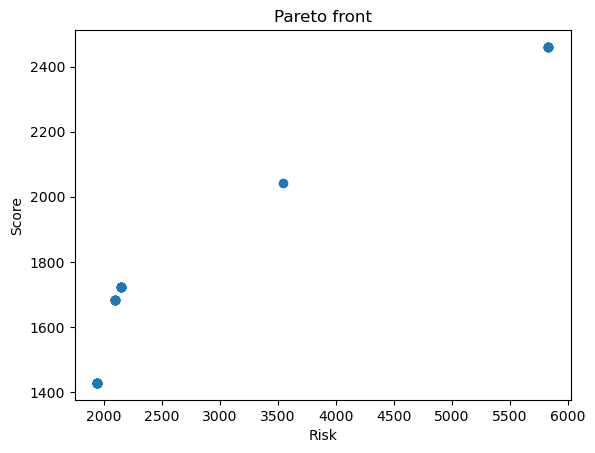

In [29]:
# plot pareto front
import matplotlib.pyplot as plt
# Plot the data
plt.scatter(f2_list, f1_list)

plt.title("Pareto front")
plt.xlabel("Risk")
plt.ylabel("Score")

# Show the plot
plt.show()

In [30]:
pd.DataFrame({'w1': w_list, 'w2': 1-w_list, 'f1':f1_list, 'f2':f2_list})

,w1,w2,f1,f2
0,0.001000,0.999000,1427.9,1946.126308
1,0.035445,0.964555,1427.9,1946.126308
2,0.069890,0.930110,1427.9,1946.126308
3,0.104334,0.895666,1427.9,1946.126308
4,0.138779,0.861221,1427.9,1946.126308
5,0.173224,0.826776,1427.9,1946.126308
6,0.207669,0.792331,1427.9,1946.126308
7,0.242114,0.757886,1427.9,1946.126308
8,0.276559,0.723441,1427.9,1946.126308
9,0.311003,0.688997,1427.9,1946.126308


In [31]:
# Display the Output for solution_no

while (True):
    sol_no = int(input("Enter solution number to see the team : "))
    if(sol_no>10 or sol_no < 0 ):
        print("Invalid Input!!. Please Choose a solution number between 0 and 9"+"(both inclusive)")
        continue
    else:
        print ('Solution number chosen is',sol_no)
        break

dr_data_set = solution_list[sol_no]
vars = dr_data_set.getVars()

print('\nThe Optimum Team for the upcoming match based on your risk tolerance and solution number is shown below:- \n')
for v in vars:
    if(int(v.VarName[2])==2 and v.x > 0):
        index=int(v.VarName[v.VarName.index(',')+1:v.VarName.index(']')])
        print('The Captain of the Team is',data_set_df.loc[index,'Player Name'] + \
          '('+ data_set_df.loc[index,'Player Type'] +')'+ ' from '+ data_set_df.loc[index,'Team'])
for v in vars:
    if(int(v.VarName[2])==1 and v.x > 0):
        index=int(v.VarName[v.VarName.index(',')+1:v.VarName.index(']')])
        print('The Vice Captain of the Team is',data_set_df.loc[index,'Player Name'] + \
              '('+ data_set_df.loc[index,'Player Type'] +')'+ ' from '+ data_set_df.loc[index,'Team']+'\n')
print('Other Players:- \n')
for v in vars:
    if(int(v.VarName[2])==0 and v.x > 0):
        index=int(v.VarName[v.VarName.index(',')+1:v.VarName.index(']')])
        print(data_set_df.loc[index,'Player Name'] +'('+ data_set_df.loc[index,'Player Type'] +')'+ \
              ' from '+ data_set_df.loc[index,'Team'])

Enter solution number to see the team : 2
Solution number chosen is 2

The Optimum Team for the upcoming match based on your risk tolerance and solution number is shown below:- 

The Captain of the Team is Virat Kohli(BAT) from INDIA
The Vice Captain of the Team is Joe Root(BAT) from ENGLAND

Other Players:- 

Abhimanyu Easwaran(BOWL) from INDIA
Dom Bess(BOWL) from ENGLAND
Jos Buttler(WKT) from ENGLAND
Wriddhiman Saha(AR) from INDIA
Ishant Sharma(AR) from INDIA
Sam Curran(AR) from ENGLAND
Haseeb Hameed(AR) from ENGLAND
Ollie Pope(BAT) from ENGLAND
Rohit Sharma(BOWL) from INDIA
